# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [125]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
print(type(y_train))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

<class 'numpy.ndarray'>
(39209, 32, 32, 3)
(39209,)
(12630, 32, 32, 3)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [126]:
### Replace each question mark with the appropriate value.
import numpy as np

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

25


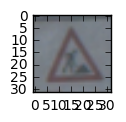

In [127]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

(<matplotlib.axes._subplots.AxesSubplot at 0x1087ef400>,
 <matplotlib.text.Text at 0x10d363978>)

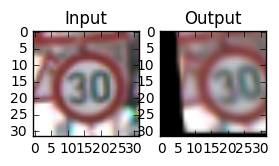

In [128]:
import matplotlib.pyplot as plt
import cv2

def rotate(image, angle):
    rows,cols,ch = image.shape
    angle = np.random.uniform(-angle,angle,1);
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst

def translate(image, shift):
    rows,cols,ch = image.shape
    tx = np.random.uniform(-shift,shift,1);
    ty = np.random.uniform(-shift,shift,1);
    M = np.float32([[1,0,tx],[0,1,ty]])
    output = cv2.warpAffine(image,M,(cols,rows))
    return output

def affine(image, shift, shear_angle):
    rows,cols,ch = image.shape
    tx = np.random.uniform(-shift,shift,1);
    ty = np.random.uniform(-shift,shift,1);
    angle = np.random.uniform(-shear_angle,shear_angle,1);
    M = np.array([[1,np.tan(angle), tx],[0, 1, ty]]);
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst

def perspective(image, d):
    rows,cols,ch = image.shape
    d = np.random.uniform(d,rows,1);
    d_min = (rows - d) // 2
    d_max = d_min + d 
    pts1 = np.float32([[d_min,d_min],[d_max,d_min],[d_min,d_max],[d_max,d_max]])
    pts2 = np.float32([[0,0],[cols,0],[0,rows],[rows,cols]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(image,M,(rows,cols))
    return dst

index = random.randint(0, len(X_train))
image = X_train[index]
output = rotate(image, 10)
output = perspective(output, 24)
output = affine(output, 5, 0.17)
plt.figure(figsize=(3,3))
plt.subplot(121),plt.imshow(image),plt.title('Input')
plt.subplot(122),plt.imshow(output),plt.title('Output')

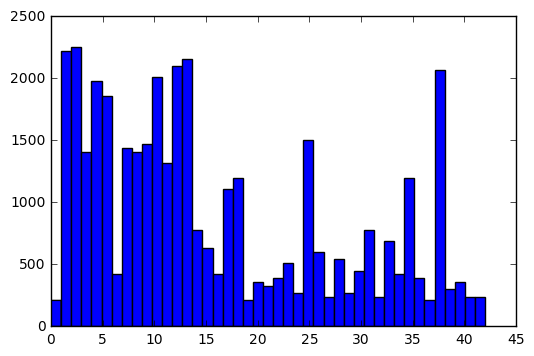

In [115]:
from collections import defaultdict

a,b,c = plt.hist(y_train,bins=43);
max_samples = a.max()

def process_image(image):
    output = rotate(image, 5)
    output = perspective(output, 28)
    output = affine(output, 5, 0.17)
    return output

def generate_new_sample():
    # create a training sample map
    X_map = defaultdict(list)
    for i in range(len(y_train)):
        X_map[y_train[i]].append(X_train[i])

    # generate enough data for each sign until equal
    x_new = []
    y_new = []
    for sign_key, sign_list in X_map.items():
        num_to_generate = int(max_samples) - len(sign_list)
        #print(max_samples, sign_key, len(sign_list), num_to_generate)
        sign_list_length = len(sign_list)
        for i in range(num_to_generate):
            index = random.randint(0, sign_list_length - 1)
            output = process_image(sign_list[index])
            x_new.append(output)
            y_new.append(sign_key)
    
    return x_new, y_new

x_new, y_new = generate_new_sample()    
X_train_new = list(X_train)
X_train_new.extend(x_new)
y_train_new = list(y_train)
y_train_new.extend(y_new)

In [116]:
def rgbToGray(rgb_images):
    n_samples = len(rgb_images)
    result = np.zeros((n_samples, 32, 32, 1))
    for i in range(n_samples):
        gray_image = cv2.cvtColor(rgb_images[i], cv2.COLOR_BGR2GRAY)
        gray_image = cv2.equalizeHist(gray_image)
        result[i]= gray_image.reshape(32,32,1)
    return result

X_train_gray = rgbToGray(X_train_new)
X_test_new = rgbToGray(X_test)

In [117]:
def normalise(data):
    data -= np.mean(data)
    data /= np.std(data)
    return data

a = np.array([200, 30, 40, 70, 0])

def normalize_grayscale(image_data):
    a = 0.0
    b = 1.0
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

X_train_gray = normalise(X_train_gray)
X_test_new = normalise(X_test_new)


In [118]:
# rename variable

X_train = X_train_gray
y_train = y_train_new
X_test = X_test_new

In [119]:
from sklearn.utils import shuffle

import tensorflow as tf

from tensorflow.contrib.layers import flatten
# Shuffle
X_train, y_train = shuffle(X_train, y_train)

# Validationn data set
percent = 30
v_num =  int((percent/100) * n_train)
X_validation = X_train[:v_num]
X_train = X_train[(n_train-v_num):]
y_validation = y_train[:v_num]
y_train = y_train[(n_train-v_num):]
    
# Network Pipeline
EPOCHS = 20
BATCH_SIZE = 128

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.05
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x24.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 24), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(24))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x24. Output = 14x14x36.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x36.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 24, 36), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(36))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x36. Output = 5x5x36.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x36. Output = 500.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 900. Output = 400.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(900, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 400. Output = 200.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(200))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
#     fc2 = tf.nn.dropout(fc2, keep_prob=0.5)
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(200, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

# Features and Labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

# Training Pipeline
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

#global_step = tf.Variable(0, trainable=False)
#starter_learning_rate = 0.01
#learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                           X_train.shape[0], 0.96, staircase=True)
# Passing global_step to minimize() will increment it at each step.
#optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#training_operation = optimizer.minimize(loss_operation, global_step=global_step)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Train the Model
def train(X_train,y_train):
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        num_examples = len(X_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

            validation_accuracy = evaluate(X_validation, y_validation)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

        saver.save(sess, 'lenet')
        print("Model saved")

train(X_train,y_train)  

Training...

EPOCH 1 ...
Validation Accuracy = 0.848

EPOCH 2 ...
Validation Accuracy = 0.922

EPOCH 3 ...
Validation Accuracy = 0.942

EPOCH 4 ...
Validation Accuracy = 0.953

EPOCH 5 ...
Validation Accuracy = 0.955

EPOCH 6 ...
Validation Accuracy = 0.956

EPOCH 7 ...
Validation Accuracy = 0.952

EPOCH 8 ...
Validation Accuracy = 0.964

EPOCH 9 ...
Validation Accuracy = 0.968

EPOCH 10 ...
Validation Accuracy = 0.965

EPOCH 11 ...
Validation Accuracy = 0.963

EPOCH 12 ...
Validation Accuracy = 0.954

EPOCH 13 ...
Validation Accuracy = 0.969

EPOCH 14 ...
Validation Accuracy = 0.970

EPOCH 15 ...
Validation Accuracy = 0.968

EPOCH 16 ...
Validation Accuracy = 0.969

EPOCH 17 ...
Validation Accuracy = 0.970

EPOCH 18 ...
Validation Accuracy = 0.968

EPOCH 19 ...
Validation Accuracy = 0.974

EPOCH 20 ...
Validation Accuracy = 0.970

Model saved


In [120]:
# Evaluate the Model
def test_model(X_test, y_test):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        
        test_accuracy = evaluate(X_test, y_test)
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        
        
test_model(X_test, y_test)


Test Accuracy = 0.938


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I preprocess the data as follow:
1. Normalise the training data to normal distribution 0 centered. The main reason to have normalization implemented is because most activation functions tapers for large values. It also makes gradient descent easier and quicker to find local minimum.
2. Convert colour image to gray scale image. This will reduce the data processing amount by 1/3, which increases training speed. However, it mihg tlose some usefult color information for detecting which I am not using for preprocessing anyway.


In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

x_new, y_new = generate_new_sample()  

# Validationn data set
percent = 30
v_num =  int((percent/100) * n_train)
X_validation = X_train[:v_num]
X_train = X_train[(n_train-v_num):]
y_validation = y_train[:v_num]
y_train = y_train[(n_train-v_num):]


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Original training data after preprocessing are split into training data and validation data with ratio 7 to 3.

I generate additional fake data to equalize the training sample for each catergory, so the network will not bias toward particular data type.

I first use image translation, affine transform, perspective transform, and histogram equalization. These are to simulate real world sign image captured by camera, and histogram equalization is just to enhance contrast, so sign can be ditinguished from dark background, hence it is easier for convolution layer to extract features.

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Please see above cell for definition
logits = LeNet(x)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The model is based on LeNet with some small adjustment on the number of filter on convolutional layer and number of connections on fully connected layers.

Layer 1: Convolutional. Input = 32x32x1. Filter Size = 5x5x24. -> LeLut activation -> pooling

Layer 2: Convolutiona2. Input = 14x14x36. Filter Size = 5x5x36. -> LeLut activation -> pooling

Layer 3: Fully Connected. Input = 900. Output = 400. -> LeLut activation

Layer 4: Fully Connected. Input = 400. Output = 200. -> LeLut activation

Layer 5: Fully Connected. Input = 200. Output = 43. 

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.
train() # please see above  

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I use Adam optimizer. I have also tried gradient decent optimizer with learning rate decay with inititial rate 0.1, which does not seem give me pretty much the same performance but with initial training speed a lot faster.  
I chose batch size to be 128, and epochs is 20 , in theory epochs can be a lot larger than 20 as we have more than enough training samples but I found my network stop performing after around 15.
Hyperparameters mu is 0 and sigma is 0.05.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I started with a standard leNet with only grayscaled and min-max[0.1-0.9] normalized image. I aslo adjusted the hyperparameter sigma to 0.05 but I only got test accuracy around 82%. 

Then I started thinking about generating more data and read some blog which gives me idea of how to apply image processing technique into generating new data. I was able to get a 88% to 89% test accuracy. 
I play around with opencv even further, try to increse the perspective transform effect, as it turns out it makes the performance worse. 

I am still not happy with the result and then start adjusting the network parameter. The major improvement comes from learning adding filter depth in the first two convolution layers, as I belive trafiic sign contain a lot of low level detail features. This brings the accuracy up to around 92%. Furthermore I increase the fully connected nueron numbers as well, whcih gives me a slight more improvement 1-2%, some time it reaches 93.7%. 

Finally I also tried different activation function to match with my normalisation technique. I tried leaky lelut with normalised data value range from -1 to 1, just thought so that it will not be cut off by original lelut activation function for negative input value. However, it does not peform any better than standard normalization and lelut which I have not figure out why, maybe I have to further debug the network to figure out but I don't have much time as it takes too long to train. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

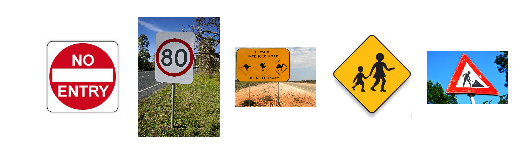

In [121]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import matplotlib.image as mpimg
import os

directory = 'web_images'
def showImages(number_of_files):
    fig = plt.figure()
    index = 0
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            index += 1
            fig.add_subplot(1,number_of_files,index)
            image = mpimg.imread(os.path.join(directory, filename))
            plt.imshow(image)
            plt.axis('off')

showImages(5)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Yes, the actual sign in the third image is quite small and it consists of three animal, which might make classification difficult. I don't think the network has been trained to regonize multiple animals in the sign.   


In [122]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
# Evaluate the Model

def generate_test_data():
    test_data = [] 
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            image = mpimg.imread(os.path.join(directory, filename))
            image = cv2.resize(image,(32,32), interpolation = cv2.INTER_CUBIC)
            test_data.append(image)
    return test_data

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                           
def evaluate_new(x_data, y_data):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        accuracy = sess.run(accuracy_operation, feed_dict={x: x_data, y:y_data})
        print("Test Accuracy = {:.3f}".format(accuracy))

test_data = generate_test_data()
x_new_data = rgbToGray(test_data)
x_new_data = normalise(x_new_data)
# manually label the sign class id
y_new_data = np.array([17,5,31,28,25])

evaluate_new(x_new_data, y_new_data)

Test Accuracy = 0.400


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

No, it seems the accuracy is only 20%

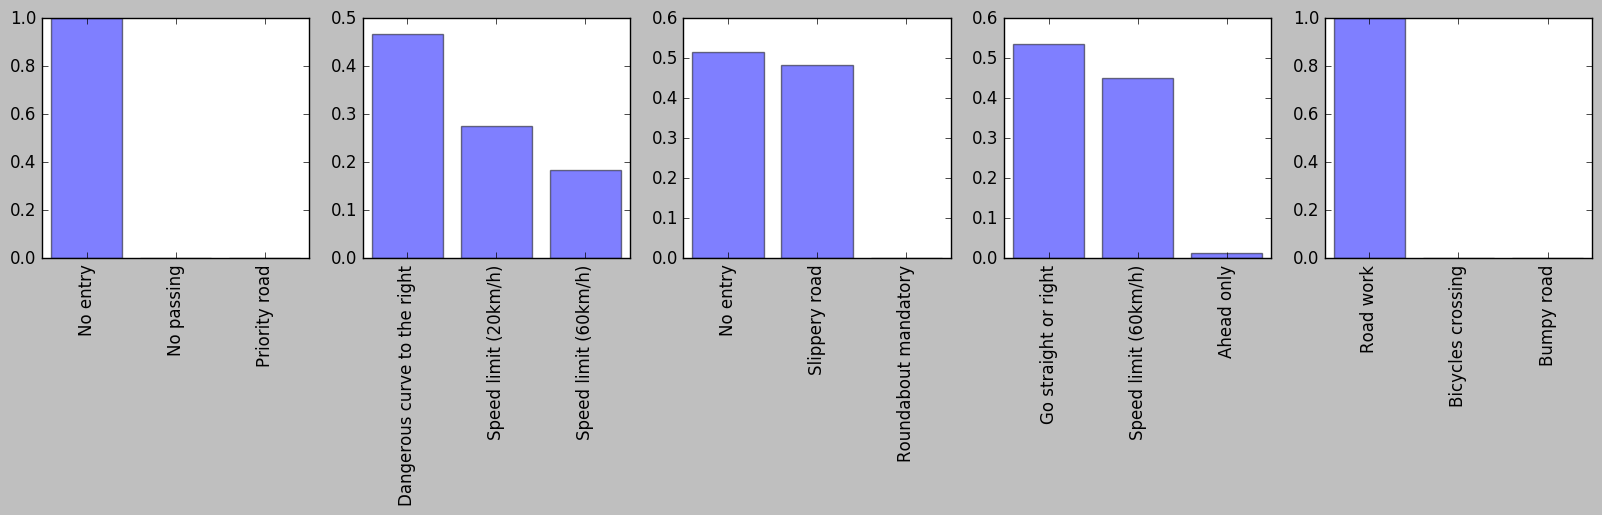

[[  1.00000000e+00   6.72631187e-26   3.72634318e-27]
 [  4.67739314e-01   2.75161058e-01   1.84652895e-01]
 [  5.16334593e-01   4.83472943e-01   1.14454124e-04]
 [  5.35274327e-01   4.51583475e-01   1.28489053e-02]
 [  1.00000000e+00   4.75033346e-10   1.18157442e-10]] [[17  9 12]
 [20  0  3]
 [17 23 40]
 [36  3 35]
 [25 29 22]]


In [123]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.]

import tensorflow as tf
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import csv

def prediction():
    prediction = tf.nn.softmax(logits)
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        output = sess.run(prediction, feed_dict={x: x_new_data, y:y_new_data})
        values, indices = sess.run(tf.nn.top_k(tf.constant(output), k=3))
    return values,indices

        
def get_sign_name(class_id):
    with open('signnames.csv', 'rt') as csvfile:
        reader = csv.reader(csvfile)
        sign_dic = {rows[0]:rows[1] for rows in reader}
        return sign_dic[str(class_id)]

def get_names(indices):
    return [get_sign_name(i) for i in indices]

def plot_softmax(values,indices):
    fig = plt.figure(figsize=(20,3))
    x_pos = np.arange(len(values[0]))
    for i in range(len(values)):
        fig.add_subplot(1,len(values),i+1)
        plt.bar(x_pos, values[i], align='center', alpha=0.5)
        sign_names = get_names(indices[i])
        plt.xticks(x_pos, sign_names, rotation='vertical')
    plt.show()

values, indices = prediction()
plot_softmax(values, indices)
print(values,indices) 


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
The model predicts two images correctly "No entry" and "child crossing" which are number 1 and 4,  It is almost 100% certain about its prediction.
However, when the prediction is wrong, the correct predictionis does not appear in the to_k.
For example, the second sign is clearly 80km/h, but the model predicts 'dangous curve to the right', and the reult is indeterministic everytime we train the model due to randomness.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.